### HENRIQUE GUIMARAES
### 10563
### 05/11/2024

# Introduction

The job shop scheduling problem (JSSP) is a well-known optimization problem in operations research and industrial engineering. It involves scheduling a set of jobs, each composed of multiple tasks that must be processed on specific machines within a given timeframe. The goal is to allocate resources (machines) effectively to minimize the overall time required to complete all jobs (makespan) while adhering to various constraints such as resource availability, job precedence, and task durations. The complexity of JSSP makes it a challenging problem suitable for constraint programming techniques.



# Goal formulation

The primary goal of this task is to create an optimal job schedule that minimizes the makespan, defined as the total time taken to complete all jobs. This will be achieved by effectively utilizing the available resources while satisfying constraints related to job dependencies, resource capacities, and specific job priorities.


# Agent's Attributes

Performance measure 
    -> Minimize makespan
    -> Ensures no overlapping of jobs on the same resource
    -> Meet job precedence requirements and resource capacity constraints

Environment 
    -> A set of jobs with specific durations and resource requirements
    -> A finite number of resources (machines) that can process jobs
    -> A temporal framework that dictates when jobs can start and finish

Actuators
    -> The scheduling algorithm that assigns start and end times for each job on the available resources.

Sensors
    -> Information from the job data, including job durations, resource assignements, and current state of the schedule
    

# Characteristics of the task environment

Dynamic because changes can occur in job priorities or durations
Partially observable because there is limited visibility into external factors affecting job scheduling, such as machine breakdowns or delays
Deterministic since it is given the same input, the schedule will always yield the same output if no external factors change
Jobs and resources are distinct entities  with specific start and finish times.

# CSP

State -> Represents a specific job configuration for job start and end times on resources
Initial State ->  All jobs are assigned but not scheduled. Only the times for each job is defined
Actions -> Assigning a job to a start time on a resource
Goal State -> All jobs are scheduled without violating any constraints, and the makespan is minimized.

# Variables and Domains

Start time -> job_starts
End time -> job_ends
Interval -> job_intervals

### Domains

The domain of each variable is defined by the maximum possible duration which is 0 to max_duration * num_jobs

### Constraints

No overlapping on same resources
Resource capacity to limit the number of jobs tha can be processed simultaneosuly on a resource
Job prioritization where specific jobs must finish by certain deadlines
Job precedence where certain jobs must finish before the next starts
Minimize makespan: Minimizes the maximum completion time across all schedule

# TODO

APPLY BACKTRACKING

# IMPORT

In [1]:
from ortools.sat.python import cp_model
import pandas as pd
import matplotlib.pyplot as plt
import re
import time

# IMPLEMENTATION

In [2]:
job_data = []
precedence_constraints = {}
resource_capacities = {}

# Parse the file
with open("p01_dataset_8.txt", "r") as file:
    lines = file.readlines()

    parsing_durations = False
    parsing_precedence = False
    parsing_resources = False

    for line in lines:
        if line.startswith("#Duration and resources"):
            parsing_durations = True
            parsing_precedence = False
            continue
        elif line.startswith("#Precedence relations"):
            parsing_precedence = True
            parsing_durations = False
            continue
        elif line.startswith("#Resource availability"):
            parsing_resources = True
            parsing_precedence = False
            continue

        if parsing_durations and not line.startswith("#"):
            parts = list(map(int, re.findall(r'\d+', line)))
            
            if len(parts) >= 5:
                job_id, duration, r1, r2 = parts[0], parts[2], parts[3], parts[4]
                job_data.append({'Job': job_id, 'Duration': duration, 'R1': r1, 'R2': r2})
            else:
                print(f"Skipping line due to insufficient data: {line}")

        if parsing_precedence and not line.startswith("#Precedence relations"):
            parts = list(map(int, re.findall(r'\d+', line)))
            if len(parts) >= 4:  # Ensure there are at least job id, #modes, #successors, and at least one successor
                job_id = parts[0]
                num_successors = parts[2]  # This is the number of successors
                successors = parts[3:3 + num_successors]  # Get the correct number of successors
                precedence_constraints[job_id] = successors

        if parsing_resources and not line.startswith("#"):
            parts = line.split()
            if len(parts) == 2:
                resource, capacity = parts
                resource_capacities[resource] = int(capacity)
            else:
                print(f"Skipping line due to insufficient data: {line}")


jobs_df = pd.DataFrame(job_data)

model = cp_model.CpModel()
resource_intervals = {'R1': [], 'R2': []}

job_starts = {}
job_ends = {}
job_intervals = {}
successor_interval = {}

num_jobs = len(jobs_df)
max_duration = sum(jobs_df['Duration']) 

for index, row in jobs_df.iterrows():
    job = row['Job']
    duration = row['Duration']
    
    start_var = model.NewIntVar(0, max_duration, f'start_{job}')
    end_var = model.NewIntVar(0, max_duration, f'end_{job}')
    interval_var = model.NewIntervalVar(start_var, duration, end_var, f'interval_{job}')
    
    job_starts[job] = start_var
    job_ends[job] = end_var
    job_intervals[job] = interval_var

    # print(f"Job {job} starts at {start_var} and ends at {end_var}")
    
printed_jobs = set()  # Initialize an empty set to track printed jobs

for job in sorted(precedence_constraints):
    if job not in printed_jobs:  # Check if the job has already been printed
        successors = precedence_constraints.get(job, [])
        if successors:
            print(f'Job {job} with successors {successors}')
        else:
            print(f'Job {job} has no successors')
        printed_jobs.add(job)  # Mark the job as printed



Skipping line due to insufficient data: ************************************************************************

Skipping line due to insufficient data: R1      1   

Skipping line due to insufficient data: R2      2

Skipping line due to insufficient data: ************************************************************************
Skipping line due to insufficient data: ************************************************************************
Job 1 with successors [2, 3]
Job 2 with successors [4]
Job 3 with successors [4]
Job 5 with successors [6, 7]
Job 6 with successors [8]
Job 7 with successors [8]


In [3]:
# Non-overlapping constraints
for job_id_i in jobs_df['Job']:
    for job_id_j in jobs_df['Job']:
        if job_id_i < job_id_j:
            model.AddNoOverlap([job_intervals[job_id_i], job_intervals[job_id_j]])

# Precedence constraints
for job_id, successors in precedence_constraints.items():
    if job_id not in job_ends or job_id not in job_starts:
        continue

    for successor in successors:
        if successor not in job_ends or successor not in job_starts:
            continue 

        if job_id != successor:
            if job_id not in precedence_constraints.get(successor, []):
                model.Add(job_ends[job_id] <= job_starts[successor])
                # print(f"Job {job_id} must end before Job {successor} starts")

# Resource constraints
for resource, capacity in resource_capacities.items():
    resource_usage = []
    for job_id, row in jobs_df.iterrows():
        job = row['Job']
        resource_usage.append(job_intervals[job])
    
    model.AddCumulative(resource_usage, [row['R1'] if resource == 'R1' else row['R2'] for index, row in jobs_df.iterrows()], capacity)
    # print(f"Resource {resource} has a capacity of {capacity}")

# Print assigned resources
# for job_id, row in jobs_df.iterrows():
#     job = row['Job']
#     print(f"Job {job} requires {row['R1']} of R1 and {row['R2']} of R2")





# SOLVE

In [4]:
def display_schedule(schedule):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_title('Job Scheduling Gantt Chart')

    # Create the Gantt bars
    for job_id, start, end in schedule:
        plt.barh(f'Job {job_id}', end - start, left=start, color='skyblue', edgecolor='black')
        plt.text(start + (end - start) / 2, f'Job {job_id}', f'Job {job_id}', ha='center', va='center', color='black', fontsize=10)  # Add job id text

    plt.xlabel('Time')
    plt.ylabel('Jobs')

    plt.grid(True, axis='x')
    plt.show()


Optimal Schedule:
Job 1 starts at 2, ends at 4, using R1: 1
Job 2 starts at 12, ends at 15, using R2: 1
Job 3 starts at 8, ends at 12, using R2: 1
Job 4 starts at 18, ends at 19, using R2: 1
Job 5 starts at 0, ends at 2, using R1: 1
Job 6 starts at 15, ends at 18, using R2: 1
Job 7 starts at 4, ends at 8, using R2: 1
Job 8 starts at 19, ends at 20, using R2: 1


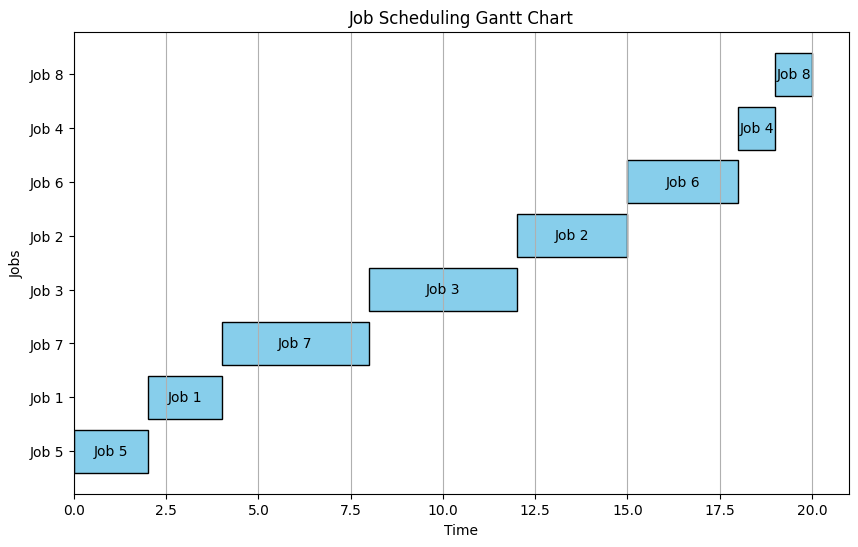

In [5]:

solver = cp_model.CpSolver()
status = solver.Solve(model)
schedule = []

if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    print("Optimal Schedule:")
    schedule = []
    for job_id in job_starts.keys():
        start_value = solver.Value(job_starts[job_id])
        end_value = solver.Value(job_ends[job_id])
        schedule.append((job_id, start_value, end_value))
        resource_r1 = jobs_df.loc[jobs_df['Job'] == job_id, 'R1'].values[0]
        resource_r2 = jobs_df.loc[jobs_df['Job'] == job_id, 'R2'].values[0]

        if resource_r1 == 0 and resource_r2 == 0:
            print(f"Job {job_id} starts at {start_value}, ends at {end_value}")
        elif resource_r1 == 0:
            print(f"Job {job_id} starts at {start_value}, ends at {end_value}, using R2: {resource_r2}")
        elif resource_r2 == 0:
            print(f"Job {job_id} starts at {start_value}, ends at {end_value}, using R1: {resource_r1}")

    # Read console input to decide if we want to sort the schedule or not
    sort_schedule = input("Do you want to sort the schedule by start time? (y/n): ")

    if sort_schedule.lower() == 'y':
        schedule.sort(key=lambda x: x[1])
        display_schedule(schedule)
    else:
        print("Displaying schedule not sorted")
        display_schedule(schedule)
else:
    print("No feasible solution found")

